In [1]:
import numpy as np
import pandas as pd
import os
import torch
import grelu.data.preprocess
import grelu.data.dataset
import grelu.lightning
import grelu.visualize
import wandb
from pytorch_lightning.loggers import WandbLogger

/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [2]:
experiment='tutorial_2'
if not os.path.exists(experiment):
    os.makedirs(experiment)

In [3]:
seq_len=2048 # Length of the input sequence
label_len=512 # Length over which we calculate total coverage
val_chroms=["chr3"]
test_chroms=["chr2"]
genome="hg38"

In [4]:
import pickle

# Load the dataset object from the file
with open('data/sum/train_ds_balanced_augmented.pkl', 'rb') as f:
    train_ds = pickle.load(f)

with open('data/sum/val_ds_balanced.pkl', 'rb') as f:
    val_ds = pickle.load(f)

with open('data/sum/test_ds_balanced.pkl', 'rb') as f:
    test_ds_bal = pickle.load(f)

with open('data/sum/test_ds_real_distribution.pkl', 'rb') as f:
    test_ds = pickle.load(f)


In [5]:
labels = np.array(test_ds.get_labels()).reshape(-1)
print(len(test_ds))
threshold = 2
thresholded_labels = np.where(labels //512 >= threshold, 1, 0)

num_ones = np.sum(thresholded_labels)
print(f"Number of datapoints equal to 1: {num_ones}")

1500
Number of datapoints equal to 1: 86


In [6]:
labels = np.array(test_ds_bal.get_labels()).reshape(-1)
print(len(test_ds_bal))
thresholded_labels = np.where(labels //512 >= threshold, 1, 0)

num_ones = np.sum(thresholded_labels)
print(f"Number of datapoints equal to 1: {num_ones}")

1500
Number of datapoints equal to 1: 764


TRAINING

In [7]:

# Initialize Wandb
wandb.init(project=experiment)
wandb_logger = WandbLogger(project=experiment)

wandb: Currently logged in as: sachn (sachn-imperial-college-london). Use `wandb login --relogin` to force relogin


In [8]:
model_params = {
    'model_type':'DilatedConvModel',
    'crop_len':(seq_len-label_len)//2,
    'n_tasks':1,
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression',
    'loss': 'poisson', # Poisson / mse / poisson_multinomial
    'logger':'csv',
    'lr':1e-3,
    'batch_size':32,
    'max_epochs':10,
    'devices':0,
    'num_workers':0,
    'save_dir':experiment,
    'optimizer': 'adam',
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params, train_params)

In [9]:
torch.mps.empty_cache()

In [ ]:
trainer = model.train_on_dataset(train_ds, val_ds)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation: |                                             | 0/? [00:00<?, ?it/s]

/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | DilatedConvModel | 5.6 M  | train
1 | loss         | PoissonNLLLoss   | 0      | train
2 | val_metrics  | MetricCollection | 0      | train
3 | test_metrics | MetricCollection | 0      | train
4 | transform    | Identity         | 0      | train
----------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.211    Total estimated model params size (MB)
118       Modules in train mode
0         Mo

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             7680.44873046875
         val_mse                 3429749.0
       val_pearson          0.05345708876848221
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck.

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [ ]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)

In [ ]:
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

In [13]:
model_path = 'tutorial_2/2024_25_08_16_15/version_0/augmented_model.pth'
torch.save(model, model_path)

In [14]:

# Define the path to your custom run directory
custom_run_directory = '/Users/sach/Desktop/jupyter-test/tutorial_2/2024_25_08_16_15/version_0'

# Create artifacts for different types of data
hparams_artifact = wandb.Artifact('hparams', type='config')
metrics_artifact = wandb.Artifact('metrics', type='dataset')
checkpoints_artifact = wandb.Artifact('checkpoints', type='model')
model_artifact = wandb.Artifact('model', type='model')

# Correctly construct file paths
hparams_file_path = os.path.join(custom_run_directory, 'hparams.yaml')
metrics_file_path = os.path.join(custom_run_directory, 'metrics.csv')
checkpoints_dir_path = os.path.join(custom_run_directory, 'checkpoints')
model_file_path = os.path.join(custom_run_directory, 'augmented_model.pth')

# Verify if the files and directory exist
if not os.path.isfile(hparams_file_path):
    raise ValueError(f"File does not exist: {hparams_file_path}")
if not os.path.isfile(metrics_file_path):
    raise ValueError(f"File does not exist: {metrics_file_path}")
if not os.path.isdir(checkpoints_dir_path):
    raise ValueError(f"Directory does not exist: {checkpoints_dir_path}")
if not os.path.isfile(model_file_path):
    raise ValueError(f"File does not exist: {model_file_path}")

# Add files to artifacts
hparams_artifact.add_file(hparams_file_path)
metrics_artifact.add_file(metrics_file_path)
checkpoints_artifact.add_dir(checkpoints_dir_path)
model_artifact.add_file(model_file_path)

# Log artifacts to Wandb
wandb.log_artifact(hparams_artifact)
wandb.log_artifact(metrics_artifact)
wandb.log_artifact(checkpoints_artifact)
wandb.log_artifact(model_artifact)


metrics_df = pd.read_csv(f'{custom_run_directory}/metrics.csv')

# Log metrics
for _, row in metrics_df.iterrows():
    wandb.log(row.to_dict())

import yaml

with open(f'{custom_run_directory}/hparams.yaml', 'r') as file:
    hyperparameters = yaml.safe_load(file)
wandb.config.update(hyperparameters)

wandb: Adding directory to artifact (/Users/sach/Desktop/jupyter-test/tutorial_2/2024_25_08_14_22/version_0/checkpoints)... Done. 0.4s


In [15]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
val_loss,▁
val_mse,▁
val_pearson,▁
epoch,9.0
step,3749.0
train_loss_epoch,nan
train_loss_step,nan
val_loss,nan
val_mse,nan


**Sum Model**

In [84]:
model_path = 'tutorial_2/2024_25_08_00_22/version_0/baseline_model.pth'
model_sum = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_74506/408900734.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [85]:
test_metrics = model_sum.test_on_dataset(
    test_ds_bal,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          5.74781967547046e+29
        test_mse                    inf
      test_pearson                  nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,inf,NaN


In [86]:
preds_sum = model_sum.predict_on_dataset(
    test_ds_bal, devices=0, num_workers=1
    )
preds_sum.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

In [87]:
mse = np.mean((preds_sum - test_ds_bal.get_labels()) ** 2)
print(f"MSE: {mse}")

rmse = np.sqrt(np.mean((preds_sum - test_ds_bal.get_labels()) ** 2))

print(f"RMSE: {rmse}")

MSE: inf
RMSE: inf


/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_74506/1732503768.py:1: RuntimeWarning: overflow encountered in square
/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_74506/1732503768.py:4: RuntimeWarning: overflow encountered in square


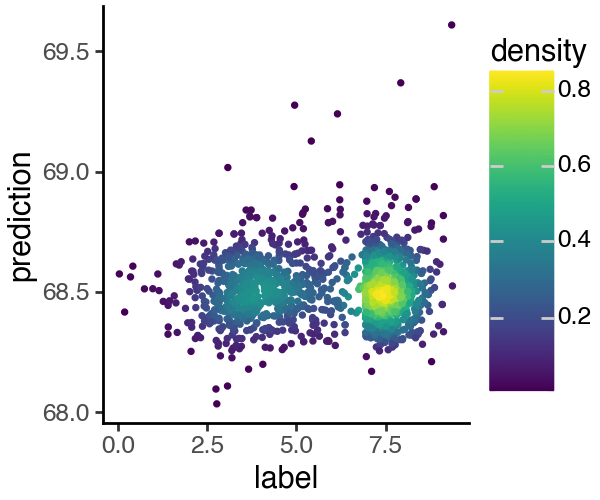

In [90]:
grelu.visualize.plot_pred_scatter(
    preds=np.log((preds_sum)),
    labels=(np.log(test_ds_bal.get_labels())),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

**AugSum Model**

In [638]:
model_path = 'model_sum_aug.pth'
model_sum_aug = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/4081584146.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [639]:
test_metrics = model_sum_aug.test_on_dataset(
    test_ds_bal,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(46070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            725.0714721679688
        test_mse                1921724.25
      test_pearson          0.26867321133613586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,1921724.25,0.268673


In [640]:
preds_sum_aug = model_sum_aug.predict_on_dataset(
    test_ds_bal, devices=0, num_workers=1
    )
preds_sum_aug.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(46078) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

In [641]:
mse = np.mean((preds_sum_aug - test_ds_bal.get_labels()) ** 2)
print(f"MSE: {mse}")

rmse = np.sqrt(np.mean((preds_sum_aug - test_ds_bal.get_labels()) ** 2))

print(f"RMSE: {rmse}")

MSE: 1921724.75
RMSE: 1386.2628173828125


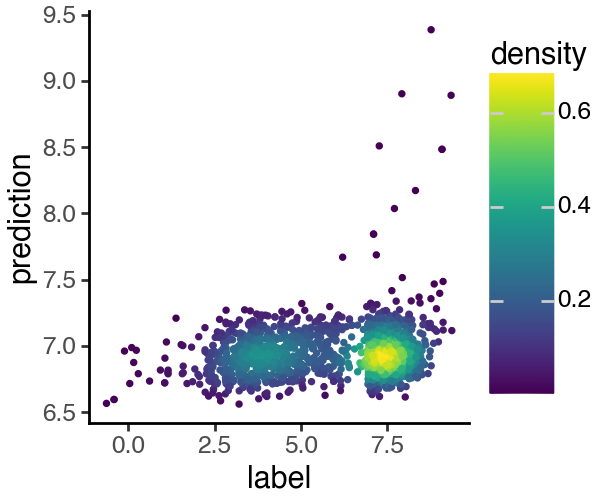

In [642]:
grelu.visualize.plot_pred_scatter(
    preds=np.log((preds_sum_aug)),
    labels=(np.log(test_ds_bal.get_labels())),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

**AugSumLRincreased Model**

In [652]:
model_path = 'model_sum_aug_lr.pth'
model_sum_aug_lr = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/2291744895.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [653]:
test_metrics = model_sum_aug_lr.test_on_dataset(
    test_ds_bal,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(46954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            743.0516967773438
        test_mse                 3329072.5
      test_pearson          0.2430175244808197
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,3329072.5,0.243018


In [658]:
preds_sum_aug_lr = model_sum_aug_lr.predict_on_dataset(
    test_ds, devices=0, num_workers=1
    )
preds_sum_aug_lr.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(47030) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

In [655]:
mse = np.mean((preds_sum_aug_lr - test_ds_bal.get_labels()) ** 2)
print(f"MSE: {mse}")

rmse = np.sqrt(np.mean((preds_sum_aug_lr - test_ds_bal.get_labels()) ** 2))

print(f"RMSE: {rmse}")

MSE: 3329075.25
RMSE: 1824.5753173828125


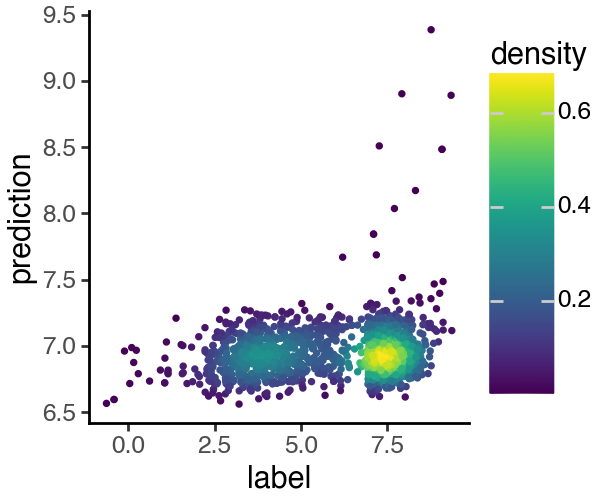

In [656]:
grelu.visualize.plot_pred_scatter(
    preds=np.log((preds_sum_aug_lr)),
    labels=(np.log(test_ds_bal.get_labels())),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

**AugSumLRDecreased Model**

In [673]:
model_path = 'model_sum_aug_lr2.pth'
model_sum_aug_lr2 = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/2577926267.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [676]:
test_metrics = model_sum_aug_lr2.test_on_dataset(
    test_ds_bal,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(47832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            742.6721801757812
        test_mse                2002826.75
      test_pearson          0.17160426080226898
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,2002826.75,0.171604


In [680]:
preds_sum_aug_lr2 = model_sum_aug_lr2.predict_on_dataset(
    test_ds, devices=0, num_workers=1
    )
preds_sum_aug_lr2.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(47863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

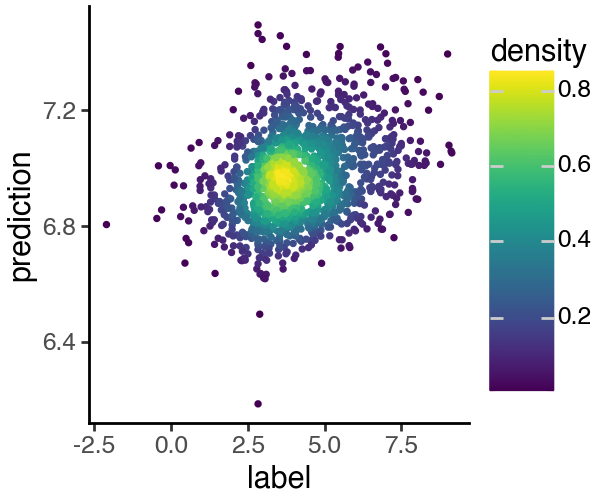

In [681]:
grelu.visualize.plot_pred_scatter(
    preds=np.log((preds_sum_aug_lr2)),
    labels=(np.log(test_ds.get_labels())),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

**Sum Model (Adam Optimiser)**

In [693]:
model_path = 'model_sum_adam.pth'
model_sum_adam = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/1732854365.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [698]:
test_metrics = model_sum_adam.test_on_dataset(
    test_ds,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(48854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            828.6209716796875
        test_mse                 1270217.0
      test_pearson          0.13518399000167847
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,1270217.0,0.135184


In [699]:
preds_sum_adam = model_sum_adam.predict_on_dataset(
    test_ds, devices=0, num_workers=1
    )
preds_sum_adam.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(48859) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

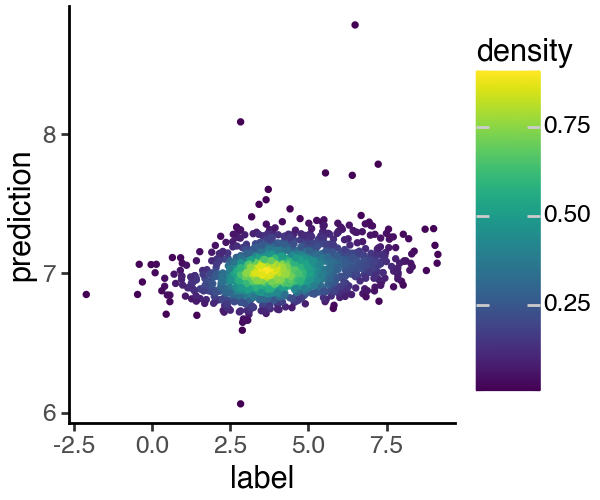

In [700]:
grelu.visualize.plot_pred_scatter(
    preds=np.log((preds_sum_adam)),
    labels=(np.log(test_ds.get_labels())),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

**sum adam 64**

In [711]:
model_path = 'model_sum_adam64.pth'
model_sum_adam64 = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/1033250475.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [712]:
test_metrics = model_sum_adam64.test_on_dataset(
    test_ds,
    batch_size=64,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(52639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            819.6902465820312
        test_mse                 1224414.0
      test_pearson          0.18126004934310913
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,1224414.0,0.18126


In [717]:
preds_sum_adam64 = model_sum_adam64.predict_on_dataset(
    test_ds, devices=0, num_workers=1
    )
preds_sum_adam64.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(52689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

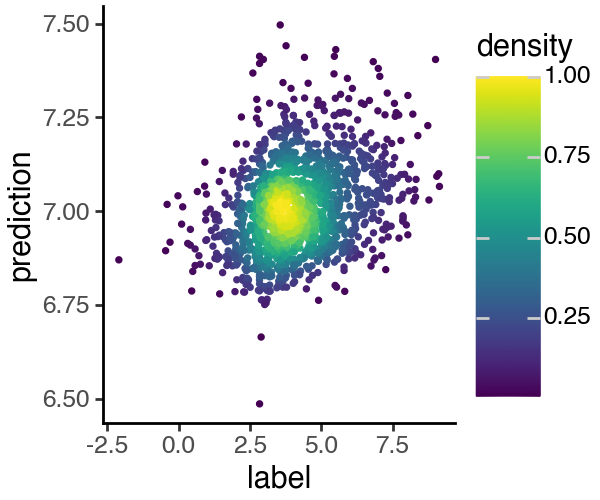

In [718]:
grelu.visualize.plot_pred_scatter(
    preds=np.log((preds_sum_adam64)),
    labels=(np.log(test_ds.get_labels())),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

**Adamval Model**

In [732]:
model_path = 'model_sum_adam_val.pth'
model_sum_adam_val = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/629170205.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [737]:
test_metrics = model_sum_adam_val.test_on_dataset(
    test_ds_bal,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(53900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            747.5210571289062
        test_mse                2015896.125
      test_pearson          0.1738918274641037
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,2015896.125,0.173892


In [738]:
preds_sum_adam_val = model_sum_adam_val.predict_on_dataset(
    test_ds_bal, devices=0, num_workers=1
    )
preds_sum_adam_val.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(53905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

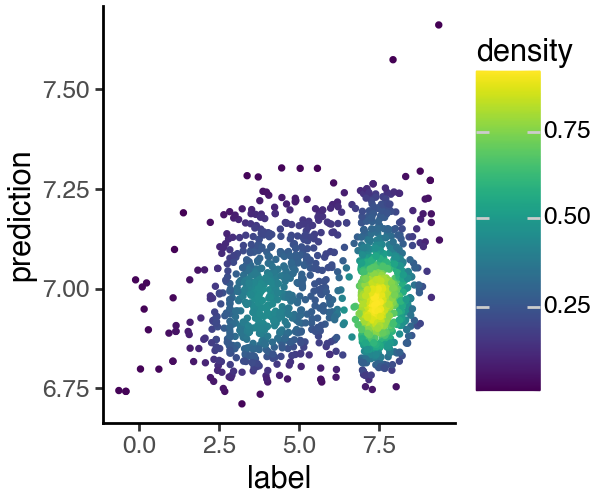

In [739]:
grelu.visualize.plot_pred_scatter(
    preds=np.log((preds_sum_adam_val)),
    labels=(np.log(test_ds_bal.get_labels())),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

**ADAMVALAUGMENTED model**

In [750]:
model_path = 'model_sum_adam_val_aug.pth'
model_sum_adam_val_aug = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/1368976150.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [756]:
test_metrics = model_sum_adam_val_aug.test_on_dataset(
    test_ds,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(54930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            653.3067626953125
        test_mse                888069.6875
      test_pearson          0.17941193282604218
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,888069.6875,0.179412


In [757]:
preds_sum_adam_val_aug = model_sum_adam_val_aug.predict_on_dataset(
    test_ds, devices=0, num_workers=1
    )
preds_sum_adam_val_aug.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(54940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

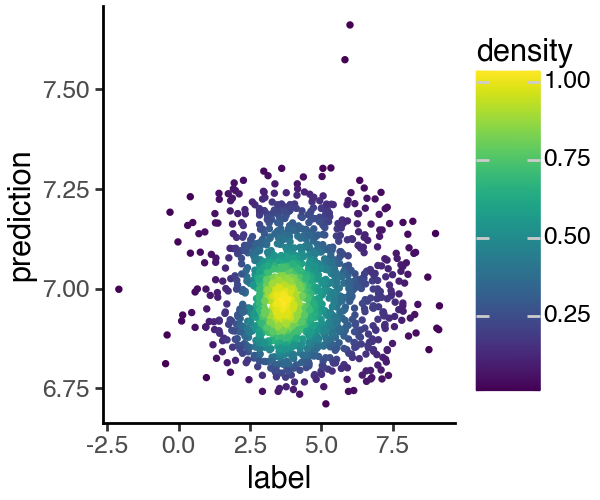

In [758]:
grelu.visualize.plot_pred_scatter(
    preds=np.log((preds_sum_adam_val)),
    labels=(np.log(test_ds.get_labels())),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

**Sum ADAM 20 Epochs Model**

In [771]:
model_path = 'model_sum_adam_20epoch.pth'
model_sum_adam_20epoch = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/1933157808.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [775]:
test_metrics = model_sum_adam_val_aug.test_on_dataset(
    test_ds_bal,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(65604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             781.24462890625
        test_mse                2092649.625
      test_pearson          0.07577115297317505
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,2092649.625,0.075771


In [776]:
preds_sum_adam_20epoch = model_sum_adam_20epoch.predict_on_dataset(
    test_ds_bal, devices=0, num_workers=1
    )
preds_sum_adam_20epoch.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(65611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

**sum adam highlr model**

In [785]:
model_path = 'model_sum_adam_highlr.pth'
model_sum_adam_highlr = torch.load(model_path)

/var/folders/ps/dcxlbxhj7p94fjxkqxxgtn140000gn/T/ipykernel_81270/1846640522.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [786]:
test_metrics = model_sum_adam_highlr.test_on_dataset(
    test_ds,
    batch_size=32,
    devices=0,
    num_workers=1
)

test_metrics

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(66324) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            768.825439453125
        test_mse                 1113288.5
      test_pearson           0.142953559756279
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
ENCFF601VTB,1113288.5,0.142954


In [787]:
preds_sum_adam_highlr = model_sum_adam_highlr.predict_on_dataset(
    test_ds, devices=0, num_workers=1
    )
preds_sum_adam_highlr.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
Python(66327) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

(1500, 1, 1)

In [621]:
def thresholded_accuracy(preds, testset, threshold):
    """
    Calculate the accuracy after applying a threshold to the predictions and labels.

    Args:
    - preds: numpy array of predictions.
    - labels: numpy array of true labels.
    - threshold: threshold value to apply to both predictions and labels.

    Returns:
    - accuracy: The percentage of correct predictions after thresholding.
    """

    preds = np.array(preds).reshape(-1)
    labels = np.array(testset.get_labels()).reshape(-1)
    
    # Reshape and apply the threshold
    thresholded_preds = np.where(preds //512 >= threshold, 1, 0)
    thresholded_labels = np.where(labels //512 >= threshold, 1, 0)

    # Calculate the accuracy
    accuracy = np.mean(thresholded_preds == thresholded_labels)
    
    return round(accuracy * 100, 1)

def recall(preds, testset, threshold):
    """
    Calculate the accuracy when both thresholded_preds and thresholded_labels are 1.

    Args:
    - preds: numpy array of predictions.
    - labels: numpy array of true labels.
    - threshold: threshold value to apply to both predictions and labels.

    Returns:
    - accuracy_pos: The accuracy for true positives.
    """
    
    preds = np.array(preds).reshape(-1)
    labels = np.array(testset.get_labels()).reshape(-1)
    
    # Reshape and apply the threshold
    thresholded_preds = np.where(preds //512 >= threshold, 1, 0)
    thresholded_labels = np.where(labels //512 >= threshold, 1, 0)

    # Calculate true positives and predicted positives
    true_positives = np.sum((thresholded_preds == 1) & (thresholded_labels == 1))
    label_positives = np.sum(thresholded_labels == 1)

    # Calculate accuracy for true positives
    if predicted_positives > 0:
        recall = true_positives / label_positives
    else:
        recall = 0  # Handle the case when there are no predicted positives
    
    return round(recall * 100, 1)

def precision(preds, testset, threshold):
    """
    Calculate the accuracy when both thresholded_preds and thresholded_labels are 1.

    Args:
    - preds: numpy array of predictions.
    - labels: numpy array of true labels.
    - threshold: threshold value to apply to both predictions and labels.

    Returns:
    - accuracy_pos: The accuracy for true positives.
    """
    
    preds = np.array(preds).reshape(-1)
    labels = np.array(testset.get_labels()).reshape(-1)
    
    # Reshape and apply the threshold
    thresholded_preds = np.where(preds //512 >= threshold, 1, 0)
    thresholded_labels = np.where(labels //512 >= threshold, 1, 0)

    # Calculate true positives and predicted positives
    true_positives = np.sum((thresholded_preds == 1) & (thresholded_labels == 1))
    preds_positives = np.sum(thresholded_preds == 1)

    # Calculate accuracy for true positives
    if predicted_positives > 0:
        precision = true_positives / preds_positives
    else:
        precision = 0  # Handle the case when there are no predicted positives
    
    return round(precision * 100, 1)

threshold = 2

In [622]:
## Sum Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum, test_ds, threshold), "%")
print("Recall:", recall(preds_sum, test_ds, threshold), "%")
print("Precision:", precision(preds_sum, test_ds, threshold), "%")

Thresholded Accuracy: 27.9 %
Recall: 94.2 %
Precision: 7.0 %


In [623]:
## Sum_aug Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_aug, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_aug, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_aug, test_ds, threshold), "%")

Thresholded Accuracy: 70.3 %
Recall: 57.0 %
Precision: 10.7 %


In [659]:
## Sum_aug_lr Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_aug_lr, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_aug_lr, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_aug_lr, test_ds, threshold), "%")

Thresholded Accuracy: 38.9 %
Recall: 88.4 %
Precision: 7.7 %


In [682]:
## Sum_aug_lr2 Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_aug_lr2, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_aug_lr2, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_aug_lr2, test_ds, threshold), "%")

Thresholded Accuracy: 44.3 %
Recall: 82.6 %
Precision: 8.0 %


In [701]:
## Sum_ADAM Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_adam, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_adam, test_ds, threshold), "%")

Thresholded Accuracy: 31.0 %
Recall: 93.0 %
Precision: 7.2 %


In [719]:
## Sum_ADAM64 Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam64, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_adam64, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_adam64, test_ds, threshold), "%")

Thresholded Accuracy: 30.5 %
Recall: 94.2 %
Precision: 7.2 %


In [736]:
## Sum_ADAM_VAL Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam_val, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_adam_val, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_adam_val, test_ds, threshold), "%")

Thresholded Accuracy: 56.8 %
Recall: 77.9 %
Precision: 9.6 %


In [759]:
## Sum_ADAM_VAL_aug Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam_val_aug, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_adam_val_aug, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_adam_val_aug, test_ds, threshold), "%")

Thresholded Accuracy: 85.1 %
Recall: 23.3 %
Precision: 11.2 %


In [774]:
## Sum_ADAM_20epoch Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam_20epoch, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_adam_20epoch, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_adam_20epoch, test_ds, threshold), "%")

Thresholded Accuracy: 44.3 %
Recall: 86.0 %
Precision: 8.2 %


In [788]:
## Sum_ADAM_highlr Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam_highlr, test_ds, threshold), "%")
print("Recall:", recall(preds_sum_adam_highlr, test_ds, threshold), "%")
print("Precision:", precision(preds_sum_adam_highlr, test_ds, threshold), "%")

Thresholded Accuracy: 48.5 %
Recall: 77.9 %
Precision: 8.2 %


In [635]:
## Sum Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum, test_ds_bal, threshold), "%")

Thresholded Accuracy: 52.7 %
Recall: 92.4 %
Precision: 52.0 %


In [636]:
## AugSum Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_aug, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_aug, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_aug, test_ds_bal, threshold), "%")

Thresholded Accuracy: 52.1 %
Recall: 53.9 %
Precision: 53.0 %


In [657]:
## AugSumLR Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_aug_lr, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_aug_lr, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_aug_lr, test_ds_bal, threshold), "%")

Thresholded Accuracy: 53.7 %
Recall: 86.1 %
Precision: 52.8 %


In [679]:
## AugSumLR2 Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_aug_lr2, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_aug_lr2, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_aug_lr2, test_ds_bal, threshold), "%")

Thresholded Accuracy: 52.9 %
Recall: 81.0 %
Precision: 52.5 %


In [697]:
## Sum_ADAM Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_adam, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_adam, test_ds_bal, threshold), "%")

Thresholded Accuracy: 52.6 %
Recall: 90.2 %
Precision: 52.0 %


In [716]:
## Sum_ADAM64 Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam64, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_adam64, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_adam64, test_ds_bal, threshold), "%")

Thresholded Accuracy: 53.1 %
Recall: 91.4 %
Precision: 52.2 %


In [740]:
## Sum_ADAM_VAL Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam_val, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_adam_val, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_adam_val, test_ds_bal, threshold), "%")

Thresholded Accuracy: 53.3 %
Recall: 69.8 %
Precision: 53.2 %


In [755]:
## Sum_ADAM_VAL_aug Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam_val_aug, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_adam_val_aug, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_adam_val_aug, test_ds_bal, threshold), "%")

Thresholded Accuracy: 47.8 %
Recall: 22.8 %
Precision: 47.4 %


In [777]:
## Sum_ADAM_20epoch Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam_20epoch, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_adam_20epoch, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_adam_20epoch, test_ds_bal, threshold), "%")

Thresholded Accuracy: 54.1 %
Recall: 81.8 %
Precision: 53.2 %


In [ ]:
## Sum_ADAM_highlr Model
print("Thresholded Accuracy:", thresholded_accuracy(preds_sum_adam_highlr, test_ds_bal, threshold), "%")
print("Recall:", recall(preds_sum_adam_highlr, test_ds_bal, threshold), "%")
print("Precision:", precision(preds_sum_adam_highlr, test_ds_bal, threshold), "%")